In [1]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from sklearn.model_selection import train_test_split 

import numpy as np
import pandas as pd
from tqdm import tqdm 
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from tqdm.auto import tqdm

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from transformers import BertConfig, BertForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup

%matplotlib inline

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=1)

In [2]:
!nvidia-smi

Wed Aug 11 19:40:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:17:00.0 Off |                  N/A |
| 62%   74C    P2   282W / 280W |   9940MiB / 11178MiB |    100%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:65:00.0 Off |                  N/A |
| 90%   

In [3]:
exp_name = 'lr_1e_3_no_val'

In [4]:
# path = '/content/drive/MyDrive/aidea_sentiment_analysis'
path = '.'

imdb_data = pd.read_csv(f'{path}/data/processed_train.csv')
imdb_test_data = pd.read_csv(f'{path}/data/processed_test.csv')

# materials = pd.read_csv(f'{path}/materials/processed_IMDB_Dataset.csv')
materials = pd.read_csv(f'{path}/materials/processed_IMDB_Dataset_raw.csv')

In [5]:
imdb_data

,ID,review,sentiment,processed_review
0,41411,I watched this film because I'm a big fan of R...,0,watch film m big fan river phoenix joaquin pho...
1,37586,It does not seem that this movie managed to pl...,1,movie manage lot people see place bump acciden...
2,6017,"Enough is not a bad movie , just mediocre .",0,bad movie mediocre
3,44656,my friend and i rented this one a few nights a...,0,friend rent night ago single good movie see me...
4,38711,"Just about everything in this movie is wrong, ...",0,movie wrong wrong wrong mike myers example s r...
...,...,...,...,...
29336,8019,It 's one of the most honest films ever made a...,1,s honest film hollywood
29337,453,An absorbing and unsettling psychological drama .,1,absorb unsettling psychological drama
29338,13097,"Soylent Green IS...a really good movie, actual...",1,soylent green good movie actually ve think don...
29339,26896,There just isn't enough here. There a few funn...,0,isn funny spot disappoint love stupid movie ex...


In [6]:
imdb_test_data

,ID,review,processed_review
0,22622,Robert Lansing plays a scientist experimenting...,robert lansing play scientist experiment pass ...
1,10162,"Well I've enjoy this movie, even though someti...",ve enjoy movie turn stereotypical situation nt...
2,17468,First things first - though I believe Joel Sch...,thing believe joel schumacher well mediocre di...
3,42579,I watched this movie on the grounds that Amber...,watch movie ground amber benson rock nick stah...
4,701,A certain sexiness underlines even the dullest...,certain sexiness underline dull tangent
...,...,...,...
29336,30370,It is difficult to rate a writer/director's fi...,difficult rate writer director s effort movie ...
29337,18654,"After watching this movie once, it quickly bec...",watch movie quickly favorite different event h...
29338,47985,"Even though i sat and watched the whole thing,...",sit watch thing good place big chunk informati...
29339,9866,Warning Spoilers following. Superb recreation ...,warn spoiler follow superb recreation base ant...


In [7]:
materials

,sentiment,processed_review
0,1,one of the other reviewers has mentioned that ...
1,1,a wonderful little production. the filming tec...
2,1,i thought this was a wonderful way to spend ti...
3,0,basically there's a family where a little boy ...
4,1,"petter mattei's ""love in the time of money"" is..."
...,...,...
49995,1,i thought this movie did a down right good job...
49996,0,"bad plot, bad dialogue, bad acting, idiotic di..."
49997,0,i am a catholic taught in parochial elementary...
49998,0,i'm going to have to disagree with the previou...


## Some preprocessing

In [8]:
# filtered weird sentiment data
imdb_data = imdb_data[~imdb_data['sentiment'].str.contains(r'[^0-9]')]

In [9]:
imdb_data

,ID,review,sentiment,processed_review
0,41411,I watched this film because I'm a big fan of R...,0,watch film m big fan river phoenix joaquin pho...
1,37586,It does not seem that this movie managed to pl...,1,movie manage lot people see place bump acciden...
2,6017,"Enough is not a bad movie , just mediocre .",0,bad movie mediocre
3,44656,my friend and i rented this one a few nights a...,0,friend rent night ago single good movie see me...
4,38711,"Just about everything in this movie is wrong, ...",0,movie wrong wrong wrong mike myers example s r...
...,...,...,...,...
29336,8019,It 's one of the most honest films ever made a...,1,s honest film hollywood
29337,453,An absorbing and unsettling psychological drama .,1,absorb unsettling psychological drama
29338,13097,"Soylent Green IS...a really good movie, actual...",1,soylent green good movie actually ve think don...
29339,26896,There just isn't enough here. There a few funn...,0,isn funny spot disappoint love stupid movie ex...


In [10]:
imdb_data['sentiment'] = imdb_data['sentiment'].astype(np.int8)
imdb_data['processed_review'] = imdb_data['processed_review'].astype(str)

imdb_test_data['processed_review'] = imdb_test_data['processed_review'].astype(str)

materials['sentiment'] = materials['sentiment'].astype(np.int8)
materials['processed_review'] = materials['processed_review'].astype(str)

imdb_data.reset_index(drop=True, inplace=True)

materials.drop_duplicates(inplace = True)

/home/ytchen/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/ytchen/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Set params

In [11]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

BATCH_SIZE = 32

num_labels = len(materials['sentiment'].unique())

class_names = [0, 1]

In [12]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [13]:
MAX_LEN = 512

## Create pytorch Dataset

Returns
* review_text
* input_ids
* attention_mask
* targets

In [14]:
class IMDB_Dataset(Dataset): # inherit from pytorch Dataset class.

    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, index): # if you want to get item via index like a list that you needs to define '__getitem__' method
        review = self.reviews[index] 
        target = self.targets[index]
        
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text = review,  # Preprocess sentence
            add_special_tokens = True,        # Add `[CLS]` and `[SEP]`
            truncation = True,               # Truncate string
            max_length = self.max_len,      # Max length to truncate/pad
            padding = 'max_length',         # Pad sentence to max length
            return_tensors = 'pt',           # Return PyTorch tensor
            return_attention_mask = True      # Return attention mask
            )

        return {
            'review_text' : review,
            'input_ids' : encoded_sent['input_ids'].flatten(), # padding 0 horizontally to transform tensor (1, MAX_LEN) 
            'attention_mask' : encoded_sent['attention_mask'].flatten(), # padding 0 horizontally to transform tensor (1, MAX_LEN) 
            'targets' : torch.tensor(target, dtype=torch.long)
        }

In [15]:
# train_df, val_df = train_test_split(materials, test_size=0.05, random_state=75)
train_df, val_df = materials, materials
print(train_df.shape, val_df.shape)

(49581, 2) (49581, 2)


In [16]:
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)

In [17]:
train_dataset = IMDB_Dataset(train_df.processed_review, train_df.sentiment, tokenizer, MAX_LEN)
val_dataset = IMDB_Dataset(val_df.processed_review, val_df.sentiment, tokenizer, MAX_LEN)

In [18]:
train_dataset[5]

{'review_text': 'probably my all-time favorite movie, a story of selflessness, sacrifice and dedication to a noble cause, but it\'s not preachy or boring. it just never gets old, despite my having seen it some 15 or more times in the last 25 years. paul lukas\' performance brings tears to my eyes, and bette davis, in one of her very few truly sympathetic roles, is a delight. the kids are, as grandma says, more like "dressed-up midgets" than children, but that only makes them more fun to watch. and the mother\'s slow awakening to what\'s happening in the world and under her own roof is believable and startling. if i had a dozen thumbs, they\'d all be "up" for this movie.',
 'input_ids': tensor([  101,  2763,  2026,  2035,  1011,  2051,  5440,  3185,  1010,  1037,
          2466,  1997,  2969, 24913,  1010,  8688,  1998, 12276,  2000,  1037,
          7015,  3426,  1010,  2021,  2009,  1005,  1055,  2025, 25250,  2100,
          2030, 11771,  1012,  2009,  2074,  2196,  4152,  2214,  101

## Wrapping Dataset with DataLoader
dataloader can be ragarded as a wrapped iterator for bucketize dataset to mini batches  

In [19]:
train_dataloader = DataLoader(dataset=train_dataset,  batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset,  batch_size=BATCH_SIZE, shuffle=True)

## Example for raw BERT usage

BERT has two kinds output 
  * pooler output : mostly used, for classification and regression
  * sequence output : for NLI (Natural Language Interaction)

In [20]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [21]:
s = 'Congratulations!That is a such great news for you!'
encoding = tokenizer.encode_plus(
    text = s,  # Preprocess sentence
    add_special_tokens = True,        # Add `[CLS]` and `[SEP]`
    max_length = 20,                  # Max length to truncate/pad
    padding = 'max_length',         # Pad sentence to max length
    return_tensors = 'pt',           # Return PyTorch tensor
    return_attention_mask = True      # Return attention mask
    )

In [22]:
o = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask'],
  output_hidden_states=True,
  output_attentions=True
)

print('I am a cool object and you can access my elements with o.last_hidden_state, o["last_hidden_state"] or even o[0]. My keys are: {} '.format(o.keys()))
print('last hidden state shape : {}'.format(o.last_hidden_state.shape))

I am a cool object and you can access my elements with o.last_hidden_state, o["last_hidden_state"] or even o[0]. My keys are: odict_keys(['last_hidden_state', 'pooler_output', 'hidden_states', 'attentions']) 
last hidden state shape : torch.Size([1, 20, 768])


In [23]:
o['last_hidden_state'][:, 0, :].shape

torch.Size([1, 768])

## Define BERT Classifier architecture

If we want to get classified prediction from BERT, except raw BERT model, we needs to define a **Feed-Forward Neural Network** and dense layer additionally. 

In [24]:
# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, n_classes, freeze_bert=True):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()

        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, n_classes

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model, to freeze part of your model and train the rest
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        # output = self.drop(outputs.pooler_output)
        # output = self.out(outputs)

        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs['last_hidden_state'][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

## BERT Classifier Usage Example (without fine-tuning)

In [25]:
model1 = BertClassifier(num_labels, freeze_bert=True)
model1 = model1.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [26]:
input_ids = encoding['input_ids'].to(device)
attention_mask = encoding['attention_mask'].to(device)

print(input_ids.shape)
print(attention_mask.shape)

torch.Size([1, 20])
torch.Size([1, 20])


In [27]:
for name, param in model1.named_parameters():                
    if param.requires_grad:
        print(name)

classifier.0.weight
classifier.0.bias
classifier.2.weight
classifier.2.bias


## Optimizer & Learning Rate Scheduler

Optimizer is for fine-tune BERT Classifier, the authors recommend following hyper-parameters:

* Batch size: 16 or 32 
* Learning rate (Adam): 5e-5, 3e-5 or 2e-5 
* Number of epochs: 2, 3, 4


What is Optimizer?

![](https://forums.fast.ai/uploads/default/original/1X/43a48f3ba8b0ace15c574f3a20a31e8eaf1396ed.png)

In [28]:
# def initialize_model_from_custom(n_classes, lr, eps, epochs):
#     """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
#     """
#     # Instantiate Bert Classifier
# #     bert_classifier = BertClassifier(n_classes, freeze_bert=True)
#     bert_classifier = BiGRU

#     # Tell PyTorch to run the model on GPU
#     bert_classifier.to(device)

#     # Create the optimizer
#     optimizer = AdamW(bert_classifier.parameters(),
#                       lr=lr,    
#                       eps=eps,
#                       # correct_bias=False    
#                       )

#     loss_fn = nn.CrossEntropyLoss().to(device)

#     loss_fn = loss_fn.to(device)
    
#     return bert_classifier, optimizer, loss_fn

In [29]:
# model, optimizer, loss_fn = initialize_model_from_custom(num_labels, lr=5e-5, eps=1e-8, epochs=EPOCHS)

## Define metric 
for calculating accuracy and evaluation that applied on training and evaluation epochs

In [30]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def binary_accuracy(preds, y):
    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [31]:
flat_accuracy(np.array([[0, 1]]), np.array([[1, 1]]))

1.0

### Use BertForSeqenceClassification as model

In [32]:
def initialize_model_from_default(n_classes, lr, eps, epochs):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate BertForSequenceClassification model
    
    config = BertConfig.from_pretrained("bert-base-uncased", num_labels=num_labels)
    model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                                    config=config)
    for param in model.base_model.parameters():
        param.requires_grad = False

    # Tell PyTorch to run the model on GPU
    model.to(device)

    # Create the optimizer
    optimizer = AdamW(model.parameters(),
                      lr=lr,    
                      eps=eps,
                      # correct_bias=False    
                      )
    
    return model, optimizer

def train(bert_classifier, train_dataloader, optimizer, scheduler):
    
    num_training_steps = 1 * len(train_dataloader)

    progress_bar = tqdm(range(num_training_steps))

    total_train_loss = []
    total_train_accuracy = 0

    size = len(train_dataloader)

    bert_classifier.train()

    for batch in train_dataloader:

        optimizer.zero_grad() # clears old gradients from the last step (otherwise you’d just accumulate the gradients from all loss.backward() calls).

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        targets = batch["targets"].to(device)

        outputs = bert_classifier(input_ids, 
                    attention_mask=attention_mask, 
                    labels=targets)

        loss, logits = outputs.loss, outputs.logits
#         print(loss.dtype)
#         print(logits.dtype)
        predictions = torch.argmax(logits, dim=-1)

        total_train_accuracy += binary_accuracy(predictions, targets)

        total_train_loss.append(loss.detach().cpu().numpy())

        loss.to(torch.float64).backward() # start backpropagation, derivative of the parameters

        torch.nn.utils.clip_grad_norm_(bert_classifier.parameters(), 1.0) # clip the norm of the gradients to 1.0 to prevent "exploding gradients"

        optimizer.step() # update parameters and the learning rate
        scheduler.step()

        progress_bar.update(1)

        
    return total_train_accuracy / size, np.mean(np.array(total_train_loss))

def eval_model(bert_classifier, val_dataloader, optimizer, scheduler):
    
    num_validation_steps = 1 * len(val_dataloader)

    progress_bar = tqdm(range(num_validation_steps))

    total_val_loss = []
    total_val_accuracy = 0

    size = len(val_dataloader)

    bert_classifier.eval()

    for batch in val_dataloader:

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        targets = batch["targets"].to(device)

        with torch.no_grad(): 
            outputs = bert_classifier(input_ids, 
                        attention_mask=attention_mask, 
                        labels=targets)

        loss, logits = outputs.loss, outputs.logits

        predictions = torch.argmax(logits, dim=-1)

        total_val_accuracy += binary_accuracy(predictions, targets)

        total_val_loss.append(loss.detach().cpu().numpy())

        progress_bar.update(1)

        
    return total_val_accuracy / size, np.mean(np.array(total_val_loss))

In [33]:
EPOCHS = 10

bert_classifier, optimizer = initialize_model_from_default(num_labels, lr=1e-3, eps=1e-8, epochs=EPOCHS)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [34]:
# Total number of training steps
total_steps = len(train_dataloader) * EPOCHS
print(f"total_steps : {total_steps}")

# Set up the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                      num_warmup_steps=0, 
                      num_training_steps=total_steps)

total_steps : 15500


### Use custom architecture model

In [35]:
# def train(bert_classifier, train_dataloader, optimizer, scheduler):
    
#     num_training_steps = 1 * len(train_dataloader)

#     progress_bar = tqdm(range(num_training_steps))

#     total_train_loss = []
#     total_train_accuracy = 0

#     size = len(train_dataloader)

#     bert_classifier.train()

#     for batch in train_dataloader:

#         optimizer.zero_grad() # clears old gradients from the last step (otherwise you’d just accumulate the gradients from all loss.backward() calls).

#         input_ids = batch["input_ids"].to(device)
#         attention_mask = batch["attention_mask"].to(device)
#         targets = batch["targets"].to(device)

#         outputs = bert_classifier(input_ids, 
#                     attention_mask=attention_mask, 
#                     labels=targets)

#         loss, logits = outputs.loss, outputs.logits
#         print(loss.dtype)
#         print(logits.dtype)
#         predictions = torch.argmax(logits, dim=-1)

#         total_train_accuracy += binary_accuracy(predictions, targets)

#         total_train_loss.append(loss.detach().cpu().numpy())

#         loss.to(torch.float64).backward() # start backpropagation, derivative of the parameters

#         torch.nn.utils.clip_grad_norm_(bert_classifier.parameters(), 1.0) # clip the norm of the gradients to 1.0 to prevent "exploding gradients"

#         optimizer.step() # update parameters and the learning rate
#         scheduler.step()

#         progress_bar.update(1)

        
#     return total_train_accuracy / size, np.mean(np.array(total_train_loss))

# def eval_model(bert_classifier, val_dataloader, optimizer, scheduler):
    
#     num_validation_steps = 1 * len(val_dataloader)

#     progress_bar = tqdm(range(num_validation_steps))

#     total_val_loss = []
#     total_val_accuracy = 0

#     size = len(val_dataloader)

#     bert_classifier.eval()

#     for batch in val_dataloader:

#         input_ids = batch["input_ids"].to(device)
#         attention_mask = batch["attention_mask"].to(device)
#         targets = batch["targets"].to(device)

#         with torch.no_grad(): 
#             outputs = bert_classifier(input_ids, 
#                         attention_mask=attention_mask, 
#                         labels=targets)

#         loss, logits = outputs.loss, outputs.logits

#         predictions = torch.argmax(logits, dim=-1)

#         total_val_accuracy += binary_accuracy(predictions, targets)

#         total_val_loss.append(loss.detach().cpu().numpy())

#         progress_bar.update(1)

        
#     return total_val_accuracy / size, np.mean(np.array(total_val_loss))

In [36]:
%%time

from collections import defaultdict

history = defaultdict(list)
best_accuracy = 0

for epoch in tqdm(range(EPOCHS)):

    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train(bert_classifier, train_dataloader, optimizer, scheduler)
    print(f'Train loss {train_loss} accuracy {train_acc}')

#     val_acc, val_loss = eval_model(bert_classifier, val_dataloader, optimizer, scheduler)
#     print(f'Val   loss {val_loss} accuracy {val_acc}')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
#     history['val_acc'].append(val_acc)
#     history['val_loss'].append(val_loss)

    if train_acc > best_accuracy:
        torch.save(bert_classifier.state_dict(), 'best_model_state.pt')
        best_accuracy = train_acc

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
----------


  0%|          | 0/1550 [00:00<?, ?it/s]

Train loss 0.5283734202384949 accuracy 0.7372798323631287
Epoch 2/10
----------


  0%|          | 0/1550 [00:00<?, ?it/s]

Train loss 0.4676148295402527 accuracy 0.7814842462539673
Epoch 3/10
----------


  0%|          | 0/1550 [00:00<?, ?it/s]

Train loss 0.456289678812027 accuracy 0.7868874669075012
Epoch 4/10
----------


  0%|          | 0/1550 [00:00<?, ?it/s]

Train loss 0.4531857967376709 accuracy 0.789103627204895
Epoch 5/10
----------


  0%|          | 0/1550 [00:00<?, ?it/s]

Train loss 0.44735634326934814 accuracy 0.7914625406265259
Epoch 6/10
----------


  0%|          | 0/1550 [00:00<?, ?it/s]

Train loss 0.44475096464157104 accuracy 0.7941951751708984
Epoch 7/10
----------


  0%|          | 0/1550 [00:00<?, ?it/s]

Train loss 0.44386544823646545 accuracy 0.7945998907089233
Epoch 8/10
----------


  0%|          | 0/1550 [00:00<?, ?it/s]

Train loss 0.44545072317123413 accuracy 0.7921077013015747
Epoch 9/10
----------


  0%|          | 0/1550 [00:00<?, ?it/s]

Train loss 0.4393983781337738 accuracy 0.7971495985984802
Epoch 10/10
----------


  0%|          | 0/1550 [00:00<?, ?it/s]

Train loss 0.43747827410697937 accuracy 0.7989640831947327
CPU times: user 2h 14min 32s, sys: 47min 20s, total: 3h 1min 52s
Wall time: 3h 1min 49s


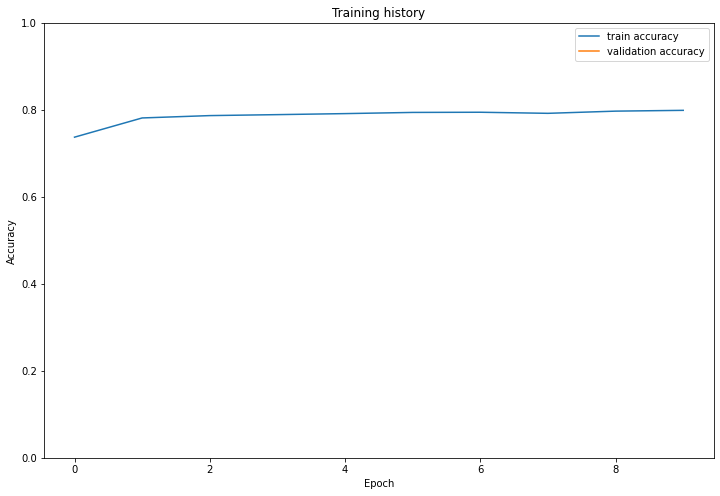

In [37]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

### Inference by model

In [38]:
# example
input_ids = encoding['input_ids'].to(device)
attention_mask = encoding['attention_mask'].to(device)
output = bert_classifier(input_ids, attention_mask)

class_names = [0, 1]

prediction = torch.max(output.logits, dim=-1)

print(f'Prediction : {prediction}')
print(f'Review text: {s}')
print(f'Sentiment  : {class_names[prediction.indices]}')

Prediction : torch.return_types.max(
values=tensor([2.8550], device='cuda:1', grad_fn=<MaxBackward0>),
indices=tensor([1], device='cuda:1'))
Review text: Congratulations!That is a such great news for you!
Sentiment  : 1


In [39]:
def model_inference(bert_classifier, text_lst, max_len, class_names):

    result = []

    bert_classifier.eval()

    for txt in tqdm(text_lst):

        # encode text
        encoded_sent = tokenizer.encode_plus(
            text = txt,  # Preprocess sentence
            add_special_tokens = True,        # Add `[CLS]` and `[SEP]`
            truncation = True,               # Truncate string
            max_length = max_len,      # Max length to truncate/pad
            padding = 'max_length',         # Pad sentence to max length
            return_tensors = 'pt',           # Return PyTorch tensor
            return_attention_mask = True      # Return attention mask
            )

        input_ids = encoded_sent['input_ids'].to(device)
        attention_mask = encoded_sent['attention_mask'].to(device)

        output = bert_classifier(input_ids, attention_mask)

        prediction = torch.max(output.logits, dim=-1)

        result.append(class_names[prediction.indices])

    return result

In [40]:
%%time
train_text = imdb_data['processed_review'].tolist()

imdb_data['pred_sentiment'] = model_inference(bert_classifier=bert_classifier, text_lst=train_text, max_len=MAX_LEN, class_names=class_names)

  0%|          | 0/29303 [00:00<?, ?it/s]

CPU times: user 9min 4s, sys: 2min 23s, total: 11min 28s
Wall time: 11min 24s


/home/ytchen/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [41]:
from sklearn.metrics import accuracy_score, classification_report

imdb_data['pred_sentiment'] = imdb_data['pred_sentiment'].astype(np.int8)

print(accuracy_score(imdb_data['sentiment'], imdb_data['pred_sentiment']))

0.7235777906698972


/home/ytchen/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [42]:
%%time
test_text = imdb_test_data['processed_review'].tolist()

imdb_test_data['pred_sentiment'] = model_inference(bert_classifier=bert_classifier, text_lst=test_text, max_len=MAX_LEN, class_names=class_names)

  0%|          | 0/29341 [00:00<?, ?it/s]

CPU times: user 9min 5s, sys: 2min 24s, total: 11min 29s
Wall time: 11min 25s


In [43]:
submission = imdb_test_data[['ID', 'pred_sentiment']]
submission.rename({'pred_sentiment':'sentiment'}, axis=1,inplace=True)
submission.to_csv(f'{path}/data/{exp_name}_submission.csv', index=0)

/home/ytchen/.local/lib/python3.6/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [44]:
submission

,ID,sentiment
0,22622,0
1,10162,0
2,17468,0
3,42579,0
4,701,0
...,...,...
29336,30370,0
29337,18654,1
29338,47985,0
29339,9866,0


## Reference

https://towardsdatascience.com/intuitive-explanation-of-bert-bidirectional-transformers-for-nlp-cdc1efc69c1e

https://www.kaggle.com/praveengovi/classify-emotions-in-text-with-bert

https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/

https://curiousily.com/posts/multi-label-text-classification-with-bert-and-pytorch-lightning/

https://github.com/bentrevett/pytorch-sentiment-analysis

https://skimai.com/fine-tuning-bert-for-sentiment-analysis/

https://mccormickml.com/2019/07/22/BERT-fine-tuning/